# Auto-sklearn tutorial

Auto-sklearn is drop-in replacement for any scikit-learn estimator.

It uses state-of-the-art AutoML technology and the scikit-learn machine learning library to provide hands-free machine learning. For more information, please visit the [documentation](https://automl.github.io/auto-sklearn/master/).

## Installation

In order to run this code, we are going to first install Auto-sklearn using pip. For more instructions on how to install Auto-sklearn, for example using conda, please check [this](https://automl.github.io/auto-sklearn/master/installation.html).

In [ ]:
!pip install auto-sklearn

## Load data

In [24]:
import sklearn.datasets
import sklearn.model_selection

# From OpenML: https://www.openml.org/d/31
X, y = sklearn.datasets.fetch_openml('credit-g', as_frame=True, return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
   X, y, random_state=42
)

## Visualize data

In [25]:
import pandas as pd
complete_df = pd.concat([y, X], axis=1)

In [26]:
complete_df.describe(include='all')

,class,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,...,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
count,1000,1000,1000.000000,1000,1000,1000.000000,1000,1000,1000.000000,1000,...,1000.000000,1000,1000.000000,1000,1000,1000.000000,1000,1000.000000,1000,1000
unique,2,4,NaN,5,10,NaN,5,5,NaN,4,...,NaN,4,NaN,3,3,NaN,4,NaN,2,2
top,good,no checking,NaN,existing paid,radio/tv,NaN,<100,1<=X<4,NaN,male single,...,NaN,car,NaN,none,own,NaN,skilled,NaN,none,yes
freq,700,394,NaN,530,280,NaN,603,339,NaN,548,...,NaN,332,NaN,814,713,NaN,630,NaN,596,963
mean,NaN,NaN,20.903000,NaN,NaN,3271.258000,NaN,NaN,2.973000,NaN,...,2.845000,NaN,35.546000,NaN,NaN,1.407000,NaN,1.155000,NaN,NaN
std,NaN,NaN,12.058814,NaN,NaN,2822.736876,NaN,NaN,1.118715,NaN,...,1.103718,NaN,11.375469,NaN,NaN,0.577654,NaN,0.362086,NaN,NaN
min,NaN,NaN,4.000000,NaN,NaN,250.000000,NaN,NaN,1.000000,NaN,...,1.000000,NaN,19.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN
25%,NaN,NaN,12.000000,NaN,NaN,1365.500000,NaN,NaN,2.000000,NaN,...,2.000000,NaN,27.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN
50%,NaN,NaN,18.000000,NaN,NaN,2319.500000,NaN,NaN,3.000000,NaN,...,3.000000,NaN,33.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN
75%,NaN,NaN,24.000000,NaN,NaN,3972.250000,NaN,NaN,4.000000,NaN,...,4.000000,NaN,42.000000,NaN,NaN,2.000000,NaN,1.000000,NaN,NaN


In [27]:
import pandas_profiling
report = pandas_profiling.ProfileReport(complete_df, title="Pandas Profiling Report")
report

Summarize dataset:   0%|          | 0/34 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Using a traditional scikit-learn pipeline

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder

# Create a simple decision tree without specifying any parameters
estimator_dt = DecisionTreeClassifier()
encoder = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='ignore'), X.dtypes == "category"),
    ],
    remainder='passthrough',
)
pipeline_dt = Pipeline([
  ('encoder', encoder),
  ('gradboost', estimator_dt),
])
pipeline_dt.fit(X_train, y_train)

# Score the model
prediction = pipeline_dt.predict_proba(X_test)
# The dataset in inbalanced - we therefore use the area under the curve as a metric
performance_dt = roc_auc_score(y_test, prediction[:, 1])
print(f"Decision Tree performance is {performance_dt}")

Decision Tree performance is 0.5764669163545568


In [30]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
# Create the estimator using the default parameters from sklearn
estimator_svc = SVC(
    C=1.0, kernel='rbf', gamma='scale', shrinking=True, tol=1e-3,
    cache_size=200, verbose=False, max_iter=-1, random_state=42, probability=True
)

# build and fit the pipeline
encoder = ColumnTransformer(transformers = [
    ('cat', OneHotEncoder(handle_unknown='ignore'), X.dtypes == "category"),
    ('cont', StandardScaler(), X.dtypes != "category"),
])

pipeline_svc = Pipeline([
    ('encoder', encoder),
    ('svc', estimator_svc),
])
pipeline_svc.fit(X_train, y_train)

# Score the model
prediction = pipeline_svc.predict_proba(X_test)
performance_svc = roc_auc_score(y_test, prediction[:, 1])
print(f"SVC performance is {performance_svc}")

SVC performance is 0.7902621722846442


In [31]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder

# Create the estimator using default parameters from sklearn
estimator_gradboost = GradientBoostingClassifier(
    learning_rate=0.1, n_estimators=100, subsample=1.0, 
    criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0,
    random_state=42
)

# build and fit the pipeline
encoder = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='ignore'), X.dtypes == "category"),
    ],
    remainder='passthrough',
)

pipeline_gradboost = Pipeline([
  ('encoder', encoder),
  ('gradboost', estimator_gradboost),
])
pipeline_gradboost.fit(X_train, y_train)

# Score the model
prediction = pipeline_gradboost.predict_proba(X_test)
performance_gradboost = roc_auc_score(y_test, prediction[:, 1])
print(f"GradientBooster performance is {performance_gradboost}")

GradientBooster performance is 0.7934612983770287


In [32]:
import autosklearn.classification
import autosklearn.metrics

# Create and train an ensemble with AutoML 
estimator_askl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=600,
    seed=42, 
    resampling_strategy='cv',
    metric=autosklearn.metrics.roc_auc,
)
# Auto-sklearn ingests the pandas dataframe and detects column types
estimator_askl.fit(X_train, y_train, dataset_name='credit-g')

# Score the model
prediction = estimator_askl.predict_proba(X_test)

In [33]:
performance_askl = roc_auc_score(y_test, prediction[:, 1])
print(f"Auto-Sklearn Classifier performance is {performance_askl}")

Auto-Sklearn Classifier performance is 0.7993913857677901


## Inspecting the output

In [34]:
print(estimator_askl.sprint_statistics())

auto-sklearn results:
  Dataset name: credit-g
  Metric: roc_auc
  Best validation score: 0.775551
  Number of target algorithm runs: 44
  Number of successful target algorithm runs: 39
  Number of crashed target algorithm runs: 1
  Number of target algorithms that exceeded the time limit: 3
  Number of target algorithms that exceeded the memory limit: 1



In [35]:
estimator_askl.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
12,1,0.10,passive_aggressive,0.224449,4.812213
13,2,0.06,qda,0.237264,3.063262
42,3,0.04,sgd,0.239085,2.942570
16,4,0.02,gradient_boosting,0.251714,15.688692
34,5,0.02,decision_tree,0.317222,4.114742
15,6,0.02,lda,0.378682,5.524902
43,7,0.50,sgd,0.420135,3.792888
39,8,0.24,sgd,0.427045,4.088530


In [36]:
print(estimator_askl.show_models())

[(0.500000, SimpleClassificationPipeline({'balancing:strategy': 'weighting', 'classifier:__choice__': 'sgd', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'robust_scaler', 'feature_preprocessor:__choice__': 'kitchen_sinks', 'classifier:sgd:alpha': 6.220098897889869e-05, 'classifier:sgd:average': 'True', 'classifier:sgd:fit_intercept': 'True', 'classifier:sgd:learning_rate': 'invscaling', 'classifier:sgd:loss': 'squared_hinge', 'classifier:sgd:penalty': 'l2', 'classifier:sgd:tol': 4.553577534269857e-05, 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.00012179955001761314, 'data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_max': 0.99426347

In [37]:
# For compatibility with scikit-learn we implement `cv_results_`
print(estimator_askl.cv_results_)

{'mean_test_score': array([0.76215857, 0.52634592, 0.74882345, 0.73797333, 0.56771187,
       0.72488457, 0.76244382, 0.68082551, 0.72701294, 0.74838299,
       0.77555098, 0.76273589, 0.71672135, 0.62131841, 0.74828624,
       0.7454031 , 0.74586627, 0.7421771 , 0.6778878 , 0.        ,
       0.74446629, 0.68206124, 0.76168396, 0.71191635, 0.        ,
       0.62348581, 0.7209267 , 0.72821852, 0.69453971, 0.73860256,
       0.50190528, 0.71839354, 0.68277765, 0.76206456, 0.        ,
       0.60458375, 0.76305003, 0.57295496, 0.75568849, 0.        ,
       0.76091479, 0.57986524, 0.73765402, 0.        ]), 'mean_fit_time': array([11.16021538,  4.21617222, 10.20782542,  4.47606444,  4.89409137,
       15.06953311,  6.06350565, 29.3063364 , 13.23681927, 21.24526787,
        4.81221342,  3.06326175, 15.50036716,  5.52490211, 15.68869233,
       10.61330056,  3.69621134, 28.24675536,  5.91152406, 60.02777004,
       11.35582304,  3.04610205,  2.59794021, 17.01826239,  0.91329908,
        3.

## Inspecting the model

### With scikit-learn

In [38]:
from sklearn.inspection import plot_partial_dependence, permutation_importance
import matplotlib.pyplot as plt
import numpy as np

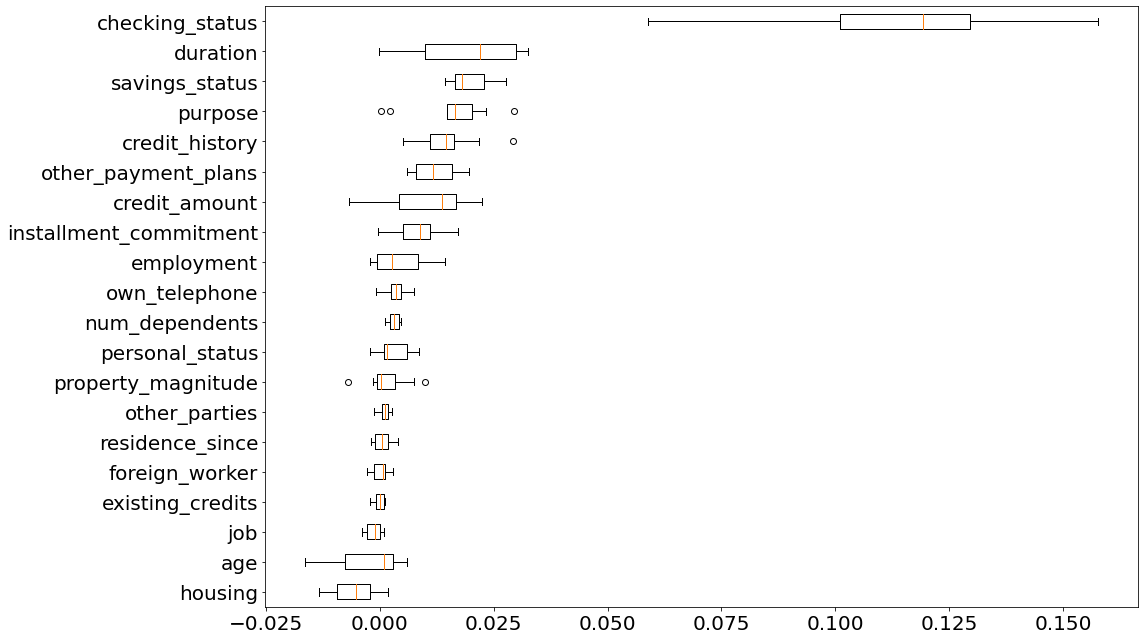

In [40]:
r = permutation_importance(
    estimator_askl, X_test, y_test,
    n_repeats=10, random_state=0, n_jobs=4,
    scoring='roc_auc',
)

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sort_idx = r.importances_mean.argsort()
ax.boxplot(r.importances[sort_idx].T, labels=[X_test.columns[i] for i in sort_idx], vert=False)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(20)
fig.tight_layout()

### Other explainers

* Can use anything that works with sklearn
* SHAP can only be used for datasets without categorical features and without missing values
* sklearn's partial dependency plots only work for datasets without categorical features and without missing values
* We have such examples in the regression notebook

## Hands-free AutoML via Auto-sklearn 2.0

In [41]:
import autosklearn.experimental.askl2
import autosklearn.metrics

# Create and train the estimator 
estimator_askl = autosklearn.experimental.askl2.AutoSklearn2Classifier(
    time_left_for_this_task=600,
    seed=42,
    metric=autosklearn.metrics.roc_auc,
)
# Auto-sklearn ingests the pandas dataframe and detects column types
estimator_askl.fit(X_train, y_train)

# Score the model
prediction = estimator_askl.predict_proba(X_test)[:, 1]

/home/feurerm/miniconda/3-4.5.4/envs/autosklearn/lib/python3.8/site-packages/smac/intensification/parallel_scheduling.py:149: UserWarning: SuccessiveHalving is intended to be used with more than 1 worker but num_workers=1
  warnings.warn("{} is intended to be used "
/home/feurerm/miniconda/3-4.5.4/envs/autosklearn/lib/python3.8/site-packages/smac/intensification/parallel_scheduling.py:149: UserWarning: SuccessiveHalving is intended to be used with more than 1 worker but num_workers=1
  warnings.warn("{} is intended to be used "
/home/feurerm/miniconda/3-4.5.4/envs/autosklearn/lib/python3.8/site-packages/smac/intensification/parallel_scheduling.py:149: UserWarning: SuccessiveHalving is intended to be used with more than 1 worker but num_workers=1
  warnings.warn("{} is intended to be used "
/home/feurerm/miniconda/3-4.5.4/envs/autosklearn/lib/python3.8/site-packages/smac/intensification/parallel_scheduling.py:149: UserWarning: SuccessiveHalving is intended to be used with more than 1 wo

/home/feurerm/miniconda/3-4.5.4/envs/autosklearn/lib/python3.8/site-packages/smac/intensification/parallel_scheduling.py:149: UserWarning: SuccessiveHalving is intended to be used with more than 1 worker but num_workers=1
  warnings.warn("{} is intended to be used "
/home/feurerm/miniconda/3-4.5.4/envs/autosklearn/lib/python3.8/site-packages/smac/intensification/parallel_scheduling.py:149: UserWarning: SuccessiveHalving is intended to be used with more than 1 worker but num_workers=1
  warnings.warn("{} is intended to be used "
/home/feurerm/miniconda/3-4.5.4/envs/autosklearn/lib/python3.8/site-packages/smac/intensification/parallel_scheduling.py:149: UserWarning: SuccessiveHalving is intended to be used with more than 1 worker but num_workers=1
  warnings.warn("{} is intended to be used "


In [42]:
performance_askl = roc_auc_score(y_test, prediction)
print(f"Auto-Sklearn Classifier performance is {performance_askl}")

Auto-Sklearn Classifier performance is 0.8113295880149812


In [43]:
estimator_askl.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
66,1,0.02,random_forest,0.231473,3.820809
60,2,0.02,extra_trees,0.240144,3.603251
27,3,0.02,sgd,0.243345,3.975553
26,4,0.04,mlp,0.248009,3.932878
44,5,0.02,mlp,0.252092,5.784833
47,6,0.02,extra_trees,0.253226,3.599239
62,7,0.76,sgd,0.275005,3.247203
28,8,0.02,mlp,0.278206,4.695140
23,9,0.02,gradient_boosting,0.282504,3.315005
